# **Ejercicio 2**

# **Ejercicio 2.1**

## **Librerías y módulos necesarios**

In [32]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from IPython.display import display

# **Contextualización**

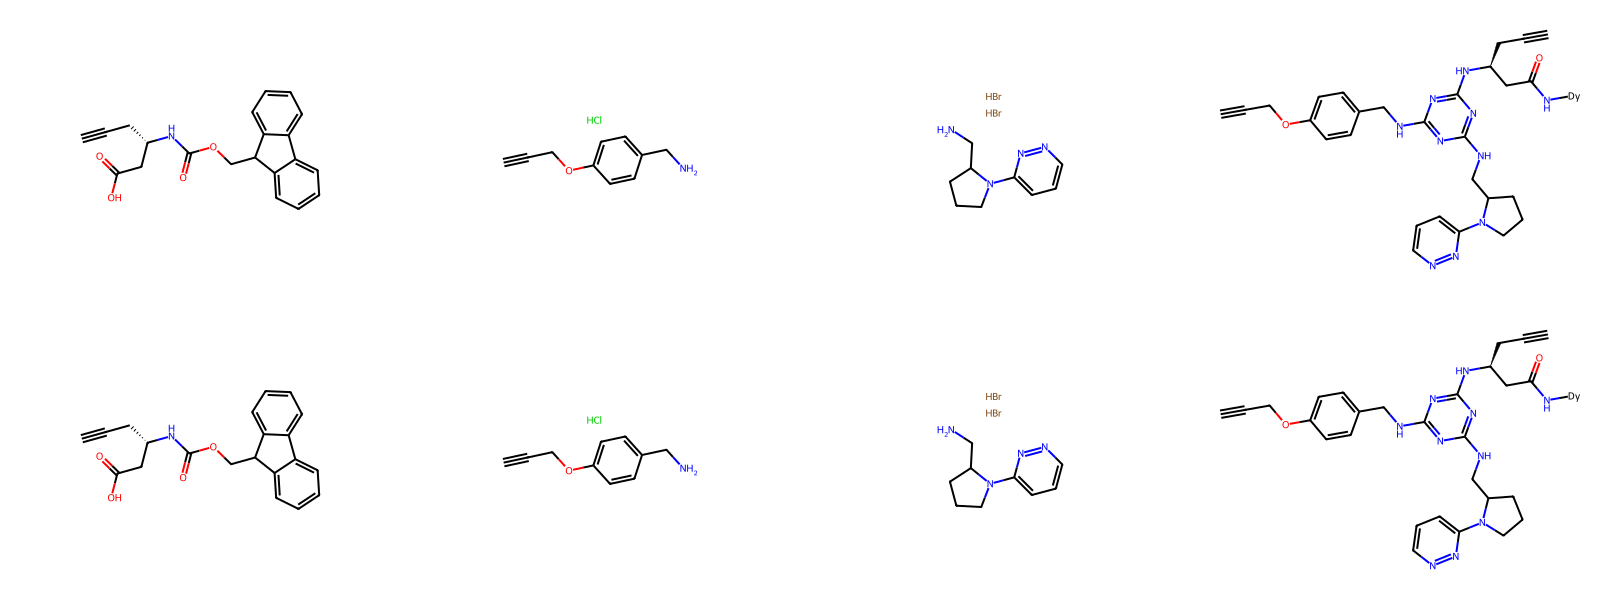

In [15]:
# Visualización de algunas moléculas.
def moleculas(data, cantidad):
    data_mol = data.reset_index(drop = True)
    mols = []
    for i in range(cantidad):
        mols += [Chem.MolFromSmiles(data_mol['buildingblock1_smiles'][i]),Chem.MolFromSmiles(data_mol['buildingblock2_smiles'][i]),
                 Chem.MolFromSmiles(data_mol['buildingblock3_smiles'][i]),Chem.MolFromSmiles(data_mol['molecule_smiles'][i])]
    return Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(400,300))

moleculas(data, 2)

# **Base de datos (Entrenamiento)**

In [8]:
data = pd.read_parquet('train.parquet', engine = 'pyarrow')

## **Características de la base de datos**

In [6]:
data.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,0,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,BRD4,0
1,1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,HSA,0
2,2,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,sEH,0
3,3,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,BRD4,0
4,4,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,HSA,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295246830 entries, 0 to 295246829
Data columns (total 7 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   id                     int64 
 1   buildingblock1_smiles  object
 2   buildingblock2_smiles  object
 3   buildingblock3_smiles  object
 4   molecule_smiles        object
 5   protein_name           object
 6   binds                  int64 
dtypes: int64(2), object(5)
memory usage: 15.4+ GB


In [8]:
data.shape

(295246830, 7)

In [10]:
data.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,295246830,295246830,295246830,295246830,295246830
unique,271,693,872,98415610,3
top,O=C(N[C@H]1CC[C@@H](C(=O)O)C1)OCC1c2ccccc2-c2c...,NCc1ccccn1,NCCc1nccc(C2CC2)n1,[N-]=[N+]=NCCC[C@H](Nc1nc(Nc2noc3ccc(F)cc23)nc...,BRD4
freq,1090407,706092,562191,3,98415610


In [11]:
binds_counts = data['binds'].value_counts(normalize = True)
binds_counts

,proportion
binds,
0,0.994615
1,0.005385


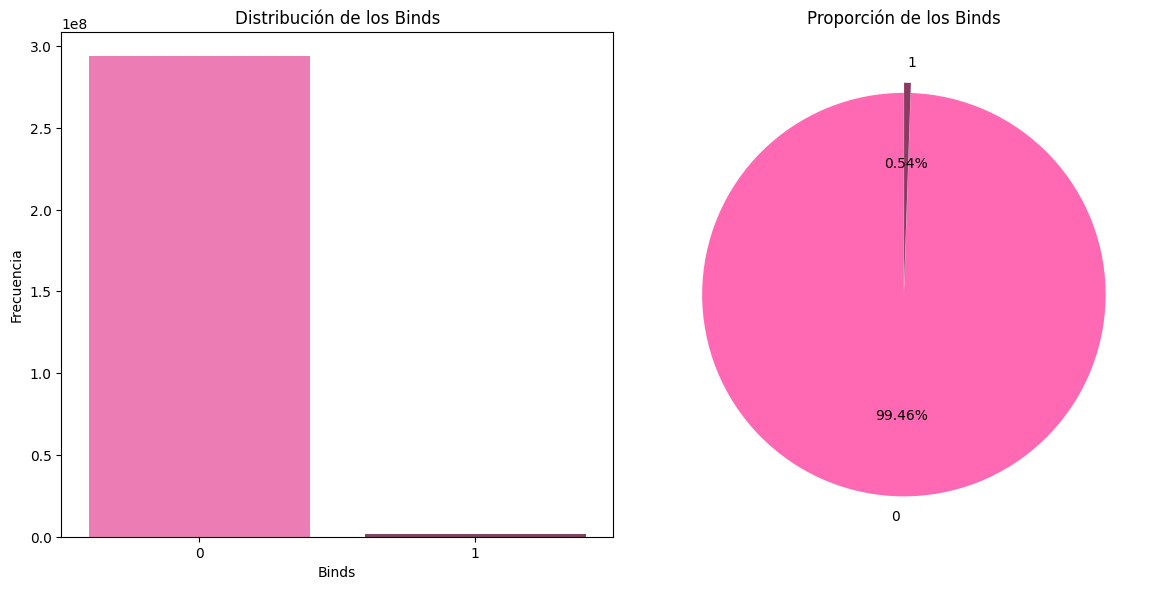

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x = data['binds'], hue = data['binds'], palette = ['#FF69B4', '#8B3A62'], legend = False, ax=axes[0])
axes[0].set_title('Distribución de los Binds')
axes[0].set_xlabel('Binds')
axes[0].set_ylabel('Frecuencia')

binds_counts.plot(kind = 'pie', autopct = '%1.2f%%', colors = ['#FF69B4', '#8B3A62'], startangle = 90, explode = (0.05, 0), ax = axes[1])
axes[1].set_title('Proporción de los Binds')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()



In [13]:
data_copy = data.copy()

## **Datos faltantes**

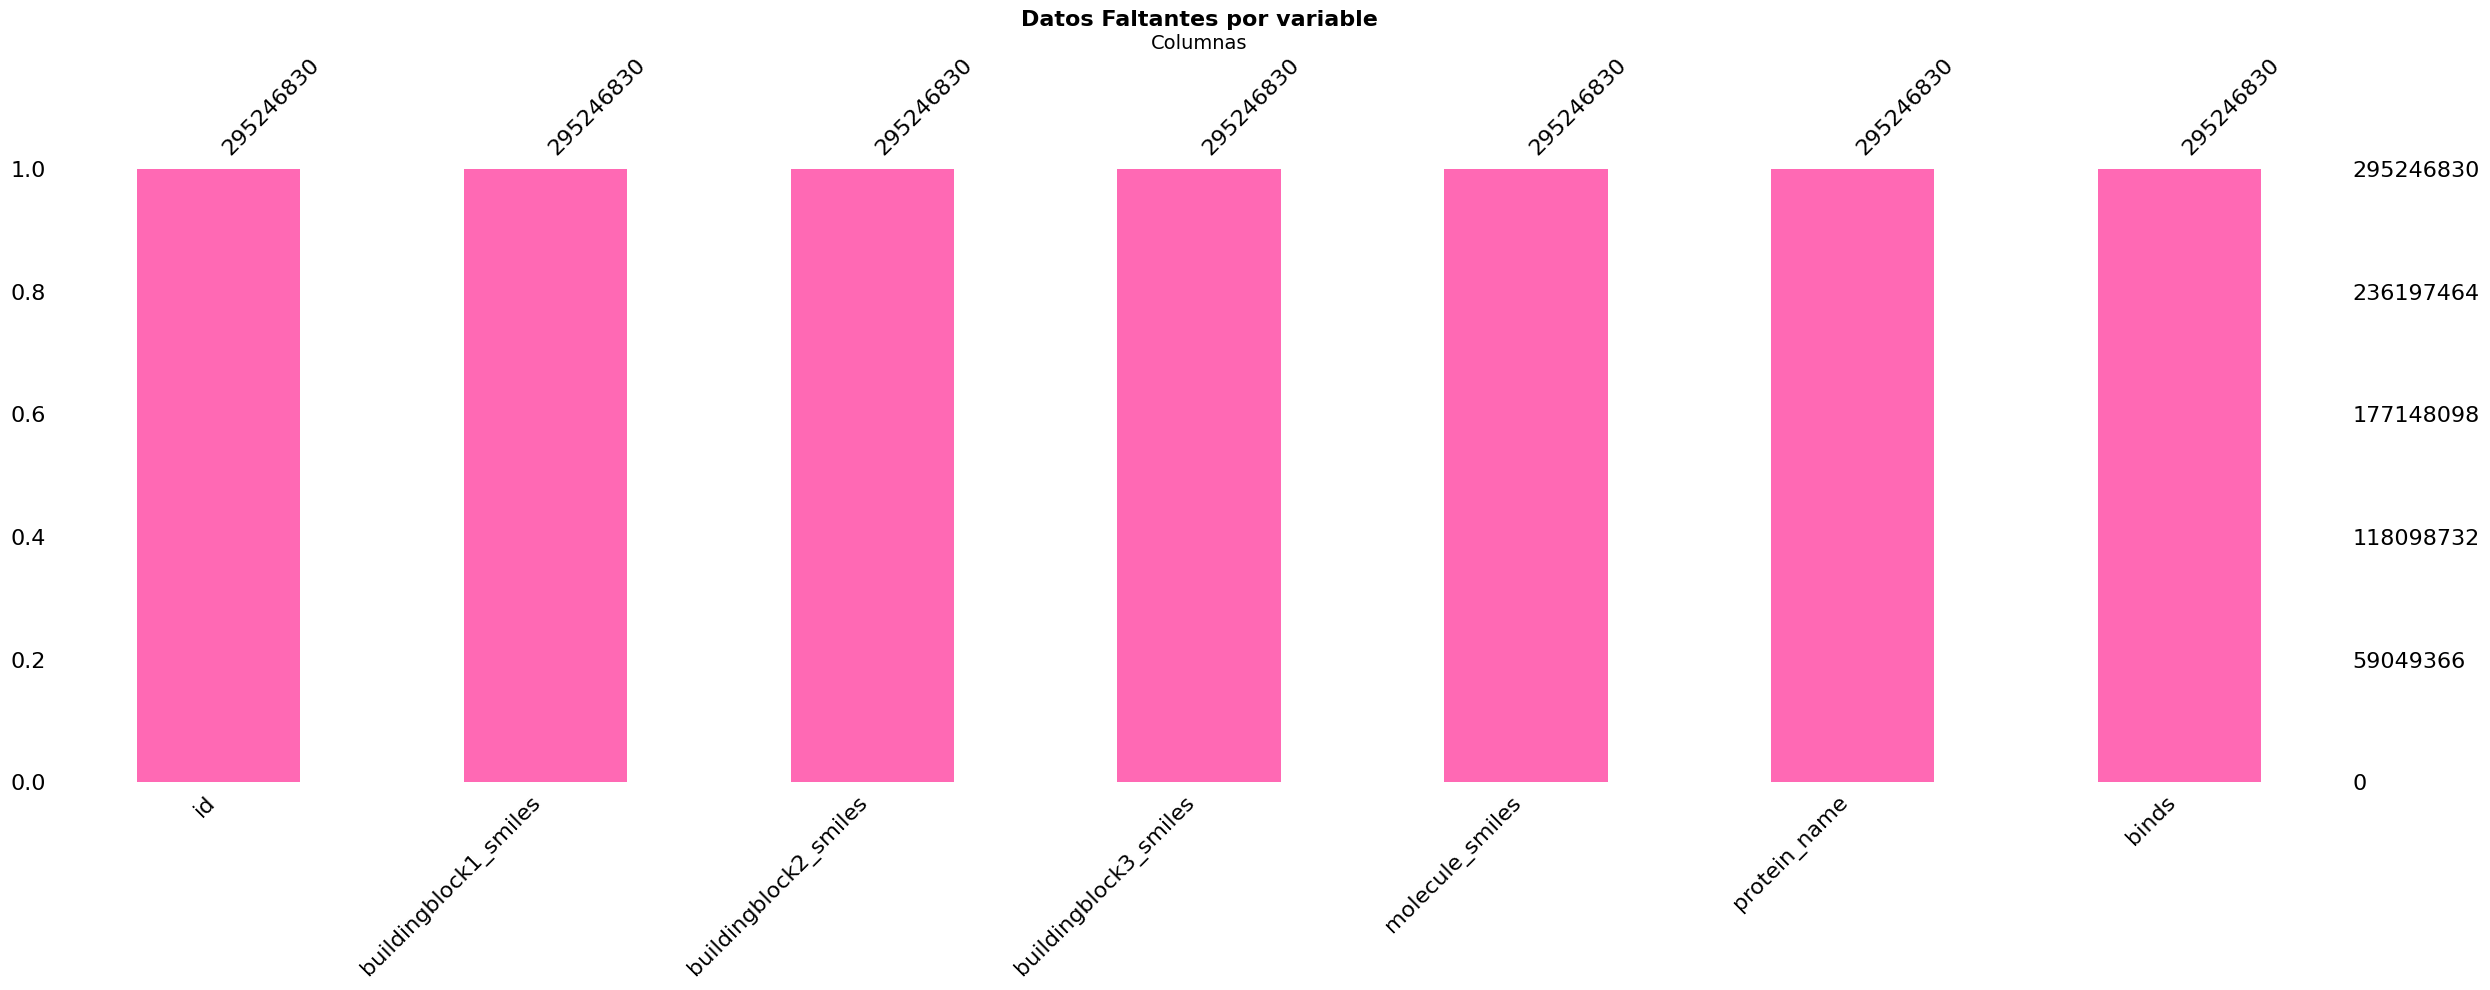

In [18]:
msno.bar(data, color = "#FF69B4", sort = 'ascending')
plt.title('Datos Faltantes por variable', fontsize = 16, fontweight = 'bold')
plt.xlabel('Columnas', fontsize = 14)
plt.ylabel('Porcentaje de Datos Faltantes', fontsize = 14)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

## **Filtración de la base de datos por proteínas**

In [19]:
proteinas = data.groupby('protein_name')['binds'].value_counts(normalize=True).unstack().reset_index()
proteinas

binds,protein_name,0,1
0,BRD4,0.995357,0.004643
1,HSA,0.995850,0.004150
2,sEH,0.992638,0.007362


In [20]:
data_proteina1 = data[data['protein_name'] == 'sEH']
data_proteina2 = data[data['protein_name'] == 'BRD4']
data_proteina3 = data[data['protein_name'] == 'HSA']

### **Proteína SEH (EPHX2)**

In [21]:
data_p1, _ = train_test_split( data_proteina1, train_size = 100000,  stratify = data_proteina1['binds'],  random_state = 11)

In [22]:
data_p1.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
147239129,147239129,O=C(Nc1c(Cl)cccc1C(=O)O)OCC1c2ccccc2-c2ccccc21,CNC(=O)COCCN.Cl,CN(CCN)C1CCOCC1,CNC(=O)COCCNc1nc(NCCN(C)C2CCOCC2)nc(Nc2c(Cl)cc...,sEH,0
257990426,257990426,O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...,Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-],Cl.NCCN1CCCS1(=O)=O,O=C(C[C@@H](Nc1nc(NCCN2CCCS2(=O)=O)nc(Nc2cc(N3...,sEH,0
180571076,180571076,O=C(Nc1ccc(Br)c(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,NCc1ccc2[nH]ccc2c1,Cc1ccc(N)nn1,Cc1ccc(Nc2nc(NCc3ccc4[nH]ccc4c3)nc(Nc3ccc(Br)c...,sEH,0
186946937,186946937,O=C(Nc1ccc(C(=O)O)c([N+](=O)[O-])c1)OCC1c2cccc...,Cl.NCc1ccc(-c2c[nH]c(=O)[nH]c2=O)cc1,Nc1ccsc1.O=C(O)C(=O)O,O=C(N[Dy])c1ccc(Nc2nc(NCc3ccc(-c4c[nH]c(=O)[nH...,sEH,0
207543668,207543668,O=C(Nc1cccc(-c2cccc(C(=O)O)c2)c1O)OCC1c2ccccc2...,Cl.NCC(=O)N1CCCO1,Nc1c(O)ncnc1O,O=C(N[Dy])c1cccc(-c2cccc(Nc3nc(NCC(=O)N4CCCO4)...,sEH,0


In [23]:
data_p1.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,100000,100000,100000,100000,100000
unique,271,693,867,100000,1
top,O=C(Nc1cc(C(=O)O)ccc1Br)OCC1c2ccccc2-c2ccccc21,CC1(CCCCN)OCCO1,CSc1nnc(CN)s1,Cc1cc(Nc2nc(Nc3ccc(C)c(Br)c3)nc(Nc3ccc([N+](=O...,sEH
freq,418,261,226,1,100000


In [24]:
data_p1.isnull().sum()

,0
id,0
buildingblock1_smiles,0
buildingblock2_smiles,0
buildingblock3_smiles,0
molecule_smiles,0
protein_name,0
binds,0


In [25]:
data_p1 = data_p1.reset_index()

In [26]:
categoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']
encoder1 = OneHotEncoder(sparse_output = False)  #La salida será una matriz densa (DataFrame de Pandas)
encoded1 = encoder1.fit_transform(data_p1[categoricas])
df_encoded1 = pd.DataFrame(encoded1, columns = encoder1.get_feature_names_out(categoricas))
df_proteina1 = pd.concat([data_p1, df_encoded1], axis = 1) # axis = 1: Indica que las columnas especificadas deben ser eliminadas
df_proteina1 = df_proteina1.drop(categoricas, axis = 1)

In [27]:
df_proteina1.head()

,index,id,molecule_smiles,binds,protein_name_sEH,buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,buildingblock3_smiles_Nc1ncnc(=O)[nH]1,buildingblock3_smiles_Nc1ncnc(Cl)c1Cl,buildingblock3_smiles_Nc1ncnc2[nH]cnc12,buildingblock3_smiles_Nc1ncnc2[nH]ncc12,buildingblock3_smiles_Nc1ncnc2c1ncn2C1CCCCO1,buildingblock3_smiles_Nc1ncncc1Br,buildingblock3_smiles_Nc1nnc(S)s1,buildingblock3_smiles_Nc1nncs1,buildingblock3_smiles_Nc1nnn[nH]1,buildingblock3_smiles_Nc1noc2ccc(F)cc12
0,147239129,147239129,CNC(=O)COCCNc1nc(NCCN(C)C2CCOCC2)nc(Nc2c(Cl)cc...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,257990426,257990426,O=C(C[C@@H](Nc1nc(NCCN2CCCS2(=O)=O)nc(Nc2cc(N3...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,180571076,180571076,Cc1ccc(Nc2nc(NCc3ccc4[nH]ccc4c3)nc(Nc3ccc(Br)c...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,186946937,186946937,O=C(N[Dy])c1ccc(Nc2nc(NCc3ccc(-c4c[nH]c(=O)[nH...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,207543668,207543668,O=C(N[Dy])c1cccc(-c2cccc(Nc3nc(NCC(=O)N4CCCO4)...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
df_proteina1.shape

(100000, 1836)

In [37]:
missing_columns1 = df_proteina1.isnull().sum()
missing_columns1= missing_columns1[missing_columns1 > 0]
print(f"Número de columnas con datos faltantes: {len(missing_columns1)}")

Número de columnas con datos faltantes: 0


In [87]:
df_proteina1.drop(columns = ['molecule_smiles'], inplace = True)
df_proteina1.drop(columns = ['id'], inplace = True)

In [88]:
y1 = df_proteina1['binds']

# Aplicar SelectKBest con chi2 para seleccionar las mejores características
k_best1 = SelectKBest(score_func = chi2, k = 100)  # Se quieren conservar k = 100 mejores características
X_new1 = k_best1.fit_transform(df_proteina1, y1)

selected_features = k_best1.get_support(indices=True)  # Obtener los índices de las características seleccionadas
proteina1 = df_proteina1.iloc[:, selected_features]

In [89]:
# Definir y1 como la variable objetivo (la columna 'binds') en el conjunto de entrenamiento y_train
ytrain = y1.copy()

In [90]:
proteina1.head()

,index,binds,buildingblock1_smiles_O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(N[C@@H](Cc1cccnc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(N[C@H](Cc1ccc(F)c(F)c1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(Nc1ccc(C(=O)O)cc1)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(Nc1ccc(C(=O)O)cc1O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(Nc1ccc(C(=O)O)nc1)OCC1c2ccccc2-c2ccccc21,...,buildingblock3_smiles_Nc1c2c(cc3c1CCC3)CCC2,buildingblock3_smiles_Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1,buildingblock3_smiles_Nc1cc(Cl)ccc1F,buildingblock3_smiles_Nc1cc(F)c(F)cc1[N+](=O)[O-],buildingblock3_smiles_Nc1ccc2c(c1)CNCC2,buildingblock3_smiles_Nc1cccc2ocnc12,buildingblock3_smiles_Nc1cncc(F)c1,buildingblock3_smiles_Nc1n[nH]c2ccc([N+](=O)[O-])cc12,buildingblock3_smiles_Nc1nc(NCc2ccc(F)cc2)ccc1[N+](=O)[O-],buildingblock3_smiles_Nc1ncco1
0,147239129,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,257990426,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,180571076,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,186946937,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,207543668,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
proteina1.shape

(100000, 100)

### **Proteína BRD4**

In [31]:
data_p2, _ = train_test_split( data_proteina2, train_size = 100000,  stratify = data_proteina2['binds'],  random_state = 11)

In [33]:
data_p2.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
100174431,100174431,O=C(N[C@@H](Cc1ccc(F)cc1F)C(=O)O)OCC1c2ccccc2-...,Nc1nc(-c2cccnc2)cs1,Cc1nnsc1CN,Cc1nnsc1CNc1nc(Nc2nc(-c3cccnc3)cs2)nc(N[C@@H](...,BRD4,0
288634638,288634638,O=C(O)[C@H]1CC2CCCCC2N1C(=O)OCC1c2ccccc2-c2ccc...,Nc1ccncc1[N+](=O)[O-],Nc1nc2nc[nH]c2c(=O)[nH]1,O=C(N[Dy])[C@H]1CC2CCCCC2N1c1nc(Nc2nc3nc[nH]c3...,BRD4,0
43808760,43808760,C[C@@H](OCc1ccccc1)[C@H](NC(=O)OCC1c2ccccc2-c2...,COc1c(F)cc(N)cc1F,Nc1ccc(F)cc1CO,COc1c(F)cc(Nc2nc(Nc3ccc(F)cc3CO)nc(N[C@H](C(=O...,BRD4,0
91037118,91037118,O=C(N[C@@H](Cc1c(F)c(F)c(F)c(F)c1F)C(=O)O)OCC1...,Cl.NCCOC1CCS(=O)(=O)C1,Cl.Cl.NCCc1nnc2c(=O)[nH]ccn12,O=C(N[Dy])[C@H](Cc1c(F)c(F)c(F)c(F)c1F)Nc1nc(N...,BRD4,0
3471777,3471777,C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,COC(=O)c1scnc1N,NCC1CSCCN1Cc1ccccc1,C#CC[C@H](CC(=O)N[Dy])Nc1nc(NCC2CSCCN2Cc2ccccc...,BRD4,0


In [34]:
data_p2.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,100000,100000,100000,100000,100000
unique,271,693,871,100000,1
top,O=C(N[C@@H](Cc1cc(F)c(F)c(F)c1)C(=O)O)OCC1c2cc...,NCCC(=O)NC1CCCC1,Cc1cc2cc(CN)ccc2[nH]1,Cc1ccc(C)c(CNc2nc(NCC3CCN(C(N)=O)C3)nc(Nc3ccc(...,BRD4
freq,436,272,233,1,100000


In [35]:
data_p2.isnull().sum()

,0
id,0
buildingblock1_smiles,0
buildingblock2_smiles,0
buildingblock3_smiles,0
molecule_smiles,0
protein_name,0
binds,0


In [38]:
data_p2 = data_p2.reset_index()

In [39]:
categoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']
encoder2 = OneHotEncoder(sparse_output = False)
encoded2 = encoder2.fit_transform(data_p2[categoricas])
df_encoded2 = pd.DataFrame(encoded2, columns = encoder2.get_feature_names_out(categoricas))
df_proteina2 = pd.concat([data_p2, df_encoded2], axis = 1)
df_proteina2 = df_proteina2.drop(categoricas, axis = 1)

In [40]:
df_proteina2.head()

,index,id,molecule_smiles,binds,protein_name_BRD4,buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,buildingblock3_smiles_Nc1ncnc(=O)[nH]1,buildingblock3_smiles_Nc1ncnc(Cl)c1Cl,buildingblock3_smiles_Nc1ncnc2[nH]cnc12,buildingblock3_smiles_Nc1ncnc2[nH]ncc12,buildingblock3_smiles_Nc1ncnc2c1ncn2C1CCCCO1,buildingblock3_smiles_Nc1ncncc1Br,buildingblock3_smiles_Nc1nnc(S)s1,buildingblock3_smiles_Nc1nncs1,buildingblock3_smiles_Nc1nnn[nH]1,buildingblock3_smiles_Nc1noc2ccc(F)cc12
0,100174431,100174431,Cc1nnsc1CNc1nc(Nc2nc(-c3cccnc3)cs2)nc(N[C@@H](...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,288634638,288634638,O=C(N[Dy])[C@H]1CC2CCCCC2N1c1nc(Nc2nc3nc[nH]c3...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,43808760,43808760,COc1c(F)cc(Nc2nc(Nc3ccc(F)cc3CO)nc(N[C@H](C(=O...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91037118,91037118,O=C(N[Dy])[C@H](Cc1c(F)c(F)c(F)c(F)c1F)Nc1nc(N...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3471777,3471777,C#CC[C@H](CC(=O)N[Dy])Nc1nc(NCC2CSCCN2Cc2ccccc...,0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
df_proteina2.shape

(100000, 1840)

In [42]:
missing_columns2 = df_proteina2.isnull().sum()
missing_columns2 = missing_columns2[missing_columns2 > 0]
print(f"Número de columnas con datos faltantes: {len(missing_columns2)}")

Número de columnas con datos faltantes: 0


In [64]:
df_proteina2.drop(columns = ['molecule_smiles'], inplace = True)
df_proteina2.drop(columns = ['id'], inplace = True)

In [65]:
y2 = df_proteina2['binds']
k_best2 = SelectKBest(score_func = chi2, k = 100)
X_new2 = k_best2.fit_transform(df_proteina2, y2)

selected_features = k_best2.get_support(indices=True)
proteina2 = df_proteina2.iloc[:, selected_features]

In [67]:
ytrain2 = y2.copy()

In [68]:
proteina2.head()

,index,binds,buildingblock1_smiles_CC(C)(C)OC(=O)CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_CC(C)(C)OCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_N#Cc1ccc(C[C@@H](NC(=O)OCC2c3ccccc3-c3ccccc32)C(=O)O)cc1,buildingblock1_smiles_O=C(NC(CC1CCCCC1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NC(CCc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,...,buildingblock3_smiles_Nc1cc(Cl)c(O)c(Cl)c1,buildingblock3_smiles_Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-],buildingblock3_smiles_Nc1ccc2[nH]ncc2c1,buildingblock3_smiles_Nc1ccc2c(c1)CCC2=O,buildingblock3_smiles_Nc1ccc2c(c1)CNC2=O,buildingblock3_smiles_Nc1ccc2c(c1)COC2=O,buildingblock3_smiles_Nc1cccnc1F,buildingblock3_smiles_Nc1nc2ccccc2s1,buildingblock3_smiles_Nc1nc2nc[nH]c2c(=O)[nH]1,buildingblock3_smiles_Nc1nccs1
0,100174431,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,288634638,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,43808760,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91037118,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3471777,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
proteina2.shape

(100000, 100)

### **Proteína HSA (ALBA)**

In [43]:
data_p3, _ = train_test_split( data_proteina3, train_size = 100000,  stratify = data_proteina3['binds'],  random_state = 11)

In [44]:
data_p3.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
79451005,79451005,O=C(NC1(C(=O)O)CCCCC1)OCC1c2ccccc2-c2ccccc21,Nc1ccnc(Cl)c1,N#Cc1cccc(N)n1,N#Cc1cccc(Nc2nc(Nc3ccnc(Cl)c3)nc(NC3(C(=O)N[Dy...,HSA,0
251510695,251510695,O=C(O)C[C@@H](Cc1ccc([N+](=O)[O-])cc1)NC(=O)OC...,Nc1ccc(O)cn1,Cn1ncc2cc(N)ccc21,Cn1ncc2cc(Nc3nc(Nc4ccc(O)cn4)nc(N[C@@H](CC(=O)...,HSA,0
50733376,50733376,Cc1cc(C(=O)O)ccc1NC(=O)OCC1c2ccccc2-c2ccccc21,Cl.NCCOC1CCS(=O)(=O)C1,Cn1nnc(N)n1,Cc1cc(C(=O)N[Dy])ccc1Nc1nc(NCCOC2CCS(=O)(=O)C2...,HSA,0
62661181,62661181,Cn1cc(C[C@@H](NC(=O)OCC2c3ccccc3-c3ccccc32)C(=...,Cl.NCC1CC(C(N)=O)=NO1,Nc1ccc(F)c(C(F)(F)F)c1,Cn1cc(C[C@@H](Nc2nc(NCC3CC(C(N)=O)=NO3)nc(Nc3c...,HSA,0
266507149,266507149,O=C(O)C[C@H](Cc1ccc(C(F)(F)F)cc1)NC(=O)OCC1c2c...,Cl.Nc1ccc(O)cc1Cl,Cc1ccnc(N)c1,Cc1ccnc(Nc2nc(Nc3ccc(O)cc3Cl)nc(N[C@H](CC(=O)N...,HSA,0


In [45]:
data_p3.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,100000,100000,100000,100000,100000
unique,271,693,871,100000,1
top,O=C(Nc1cc(Br)cc(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,NCc1c(F)cccc1N1CCCC1,Cc1nc(Cl)c(N)c(Cl)n1,COc1ccncc1CNc1nc(Nc2cnc(C)cn2)nc(N2CCC[C@H]2C(...,HSA
freq,435,281,224,1,100000


In [46]:
data_p3.isnull().sum()

,0
id,0
buildingblock1_smiles,0
buildingblock2_smiles,0
buildingblock3_smiles,0
molecule_smiles,0
protein_name,0
binds,0


In [75]:
data_p3 = data_p3.reset_index()

In [84]:
categoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']
encoder3 = OneHotEncoder(sparse_output = False)
encoded3 = encoder3.fit_transform(data_p3[categoricas])
df_encoded3 = pd.DataFrame(encoded3, columns = encoder3.get_feature_names_out(categoricas))
df_proteina3 = pd.concat([data_p3, df_encoded3], axis = 1)
df_proteina3 = df_proteina3.drop(categoricas, axis = 1)

In [81]:
df_proteina3.head()

,level_0,index,id,molecule_smiles,binds,protein_name_HSA,buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,...,buildingblock3_smiles_Nc1ncnc(=O)[nH]1,buildingblock3_smiles_Nc1ncnc(Cl)c1Cl,buildingblock3_smiles_Nc1ncnc2[nH]cnc12,buildingblock3_smiles_Nc1ncnc2[nH]ncc12,buildingblock3_smiles_Nc1ncnc2c1ncn2C1CCCCO1,buildingblock3_smiles_Nc1ncncc1Br,buildingblock3_smiles_Nc1nnc(S)s1,buildingblock3_smiles_Nc1nncs1,buildingblock3_smiles_Nc1nnn[nH]1,buildingblock3_smiles_Nc1noc2ccc(F)cc12
0,0,79451005,79451005,N#Cc1cccc(Nc2nc(Nc3ccnc(Cl)c3)nc(NC3(C(=O)N[Dy...,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,251510695,251510695,Cn1ncc2cc(Nc3nc(Nc4ccc(O)cn4)nc(N[C@@H](CC(=O)...,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,50733376,50733376,Cc1cc(C(=O)N[Dy])ccc1Nc1nc(NCCOC2CCS(=O)(=O)C2...,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,62661181,62661181,Cn1cc(C[C@@H](Nc2nc(NCC3CC(C(N)=O)=NO3)nc(Nc3c...,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,266507149,266507149,Cc1ccnc(Nc2nc(Nc3ccc(O)cc3Cl)nc(N[C@H](CC(=O)N...,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
df_proteina3.shape

(100000, 1841)

In [58]:
missing_columns3 = df_proteina3.isnull().sum()
missing_columns3 = missing_columns3[missing_columns3 > 0]
print(f"Número de columnas con datos faltantes: {len(missing_columns3)}")

Número de columnas con datos faltantes: 0


In [86]:
df_proteina3.drop(columns = ['molecule_smiles'], inplace = True)
df_proteina3.drop(columns = ['id'], inplace = True)

In [70]:
y3 = df_proteina3['binds']

# Aplicar SelectKBest con chi2 para seleccionar las mejores características
k_best3 = SelectKBest(score_func = chi2, k = 100)  # Se quieren conservar k = 100 mejores características
X_new3 = k_best3.fit_transform(df_proteina3, y3)

selected_features = k_best3.get_support(indices=True)  # Obtener los índices de las características seleccionadas
proteina3 = df_proteina3.iloc[:, selected_features]

In [71]:
# Definir y3 como la variable objetivo (la columna 'binds') en el conjunto de entrenamiento y_train
ytrain = y3.copy()

In [72]:
proteina3.head()

,index,binds,buildingblock1_smiles_CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_Cc1cc(Cl)cc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_Cc1ccc(C(=O)O)cc1NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NC(CC1CCCCC1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(N[C@@H](Cc1cccnc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(N[C@H](Cc1ccc(-c2ccccc2)cc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(Nc1cc(C(=O)O)cc(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,...,buildingblock3_smiles_Nc1cccc2ocnc12,buildingblock3_smiles_Nc1cn[nH]c1,buildingblock3_smiles_Nc1cncc(F)c1,buildingblock3_smiles_Nc1n[nH]c2cc(F)ccc12,buildingblock3_smiles_Nc1nc(Cl)c2[nH]cnc2n1,buildingblock3_smiles_Nc1nc2c(s1)CN(C(=O)OCc1ccccc1)CC2,buildingblock3_smiles_Nc1nc[nH]n1,buildingblock3_smiles_Nc1ncnc(Cl)c1Cl,buildingblock3_smiles_Nc1nncs1,buildingblock3_smiles_Nc1nnn[nH]1
0,79451005,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,251510695,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,50733376,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62661181,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,266507149,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
proteina3.shape

(100000, 100)

# **Base de datos (Test)**


In [ ]:
datos = pd.read_parquet('test.parquet', engine = 'pyarrow')

In [ ]:
datos.shape

(1674896, 6)

In [ ]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1674896 entries, 0 to 1674895
Data columns (total 6 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   id                     1674896 non-null  int64 
 1   buildingblock1_smiles  1674896 non-null  object
 2   buildingblock2_smiles  1674896 non-null  object
 3   buildingblock3_smiles  1674896 non-null  object
 4   molecule_smiles        1674896 non-null  object
 5   protein_name           1674896 non-null  object
dtypes: int64(1), object(5)
memory usage: 76.7+ MB


In [ ]:
datos.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,1674896,1674896,1674896,1674896,1674896
unique,341,1140,1389,878022,3
top,O=C(N[C@@H]1CCN(c2cc(C(=O)O)cc(Cl)n2)C1)OCC1c2...,Nc1nc(NCc2ccc(F)cc2)ccc1[N+](=O)[O-],Cl.Cl.NCCc1nnc2c(=O)[nH]ccn12,[N-]=[N+]=NCCC[C@H](Nc1nc(NCc2cccs2)nc(Nc2noc3...,BRD4
freq,14098,14637,10323,3,558859


In [ ]:
data_sampled.isnull().sum()

,0
index,0
id,0
buildingblock1_smiles,0
buildingblock2_smiles,0
buildingblock3_smiles,0
molecule_smiles,0
protein_name,0
binds,0


In [ ]:
datos_filtered = datos[datos['protein_name'] == 'sEH']

In [ ]:
datos_filtered.shape

(558142, 6)

In [ ]:
datos_filtered.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
2,295246832,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,C=Cc1ccc(N)cc1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,sEH
5,295246835,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CC(O)Cn1cnc2c(N)ncnc21,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,sEH
8,295246838,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CC1(C)CCCC1(O)CN,C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...,sEH
11,295246841,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,COC(=O)c1cc(Cl)sc1N,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...,sEH
14,295246844,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CSC1CCC(CN)CC1,C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...,sEH


In [ ]:
# Seleccionar 50,000 observaciones de forma aleatoria
sampled_df = datos_filtered.sample(n=30000, random_state=11)


In [ ]:
sampled_df.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,30000,30000,30000,30000,30000
unique,341,1139,1366,30000,1
top,CC(C)(C)OC(=O)N1C[C@@H](C(=O)O)[C@H](c2cccc(Br...,Nc1nc(NCc2ccc(F)cc2)ccc1[N+](=O)[O-],Cl.Cl.NCCc1nnc2c(=O)[nH]ccn12,CCOC(=O)c1cnc(SC)nc1Nc1nc(NC[C@@H]2CCC(=O)N2)n...,sEH
freq,281,253,165,1,30000


In [ ]:
sampled_df.describe()

,id
count,3.000000e+04
mean,2.960891e+08
std,4.831441e+05
min,2.952469e+08
25%,2.956691e+08
50%,2.960929e+08
75%,2.965111e+08
max,2.969217e+08


In [ ]:
sampled_df.shape

(50000, 6)

In [ ]:
# Seleccionar las columnas categóricas sin caracteres especiales extra
categorical_columns = ['molecule_smiles','protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']

# Crear una instancia de OneHotEncoder
encoder2 = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # handle_unknown='ignore' para manejar categorías no vistas

# Aplicar OneHotEncoder a las columnas categóricas seleccionadas
one_hot_encoded2 = encoder2.fit_transform(sampled_df[categorical_columns])

# Convertir el resultado en un DataFrame
one_hot_df2 = pd.DataFrame(one_hot_encoded2, columns=encoder2.get_feature_names_out(categorical_columns))

# Concatenar las columnas codificadas con el DataFrame original
sample_df = pd.concat([sampled_df, one_hot_df2], axis=1)

# Eliminar las columnas categóricas originales
sample_df = sample_df.drop(categorical_columns, axis=1)


In [ ]:
df_encoded.head()

,level_0,index,id,binds,molecule_smiles_C#CCOc1ccc(CNc2nc(NCC(=O)N(C)OCC)nc(Nc3ccc(C(=O)N[Dy])cc3OC(F)(F)F)n2)cc1,molecule_smiles_C#CCOc1ccc(CNc2nc(NCC(=O)NC3(C#N)CC3)nc(Nc3cccc(C)c3C(=O)N[Dy])n2)cc1,molecule_smiles_C#CCOc1ccc(CNc2nc(NCC(=O)N[Dy])nc(NCc3c(F)cccc3OC)n2)cc1,molecule_smiles_C#CCOc1ccc(CNc2nc(NCC(C)(CC(C)C)NC(=O)c3cc(Cl)c(Cl)[nH]3)nc(Nc3cnccc3C(=O)N[Dy])n2)cc1,molecule_smiles_C#CCOc1ccc(CNc2nc(NCC(C)Cn3cccn3)nc(N[C@H](CC(=O)N[Dy])c3cccc(Cl)c3)n2)cc1,molecule_smiles_C#CCOc1ccc(CNc2nc(NCC(C)OCC=C)nc(Nc3cccc(OC)c3C(=O)N[Dy])n2)cc1,...,buildingblock3_smiles_Nc1ncnc(=O)[nH]1,buildingblock3_smiles_Nc1ncnc(Cl)c1Cl,buildingblock3_smiles_Nc1ncnc2[nH]cnc12,buildingblock3_smiles_Nc1ncnc2[nH]ncc12,buildingblock3_smiles_Nc1ncnc2c1ncn2C1CCCCO1,buildingblock3_smiles_Nc1ncncc1Br,buildingblock3_smiles_Nc1nnc(S)s1,buildingblock3_smiles_Nc1nncs1,buildingblock3_smiles_Nc1nnn[nH]1,buildingblock3_smiles_Nc1noc2ccc(F)cc12
0,0,169587653,169587653,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,217503845,217503845,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,93117155,93117155,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,32383010,32383010,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,292712435,292712435,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_encoded.shape

(50000, 51833)

In [ ]:
missing_columns = df_encoded.isnull().sum()
missing_columns = missing_columns[missing_columns > 0]
missing_columns

,0


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

# Definir X como el DataFrame sin la columna 'binds'
X = df_encoded.drop('binds', axis=1)

# Definir y como la variable objetivo (la columna 'binds')
y = df_encoded['binds']

# Aplicar SelectKBest con chi2 para seleccionar las mejores características
k_best = SelectKBest(score_func=chi2, k=100)  # Ajusta k según la cantidad de características que quieras conservar
X_new = k_best.fit_transform(X, y)

# Obtener los índices de las características seleccionadas
selected_features = k_best.get_support(indices=True)

# Crear un DataFrame con las características seleccionadas
one_hot_df_reduced = X.iloc[:, selected_features]

# Añadir nuevamente la variable objetivo 'binds' al DataFrame reducido
one_hot_df_reduced['binds'] = y.values



<ipython-input-35-4e9c6e4229da>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_hot_df_reduced['binds'] = y.values


In [ ]:
one_hot_df_reduced.head()

,index,id,molecule_smiles_NC(=O)c1cc(CNc2nc(Nc3ccc(C(=O)N[Dy])c([N+](=O)[O-])c3)nc(Nc3nncs3)n2)ccn1,molecule_smiles_O=C(CC(Nc1nc(NCc2ccsc2Br)nc(Nc2cc(Cl)cnc2Cl)n1)c1ccc(Br)cc1)N[Dy],molecule_smiles_O=C(CC(Nc1nc(NCc2cncc(F)c2)nc(Nc2n[nH]c3c(Cl)cc([N+](=O)[O-])cc23)n1)c1ccc(Br)cc1)N[Dy],molecule_smiles_O=C(CCNc1nc(NCC2CCC(C(=O)N[Dy])CC2)nc(Nc2ncnc(=O)[nH]2)n1)NC1CCCC1,molecule_smiles_O=C(CCNc1nc(NCC[C@@H]2COC[C@H]2O)nc(NC[C@H]2CC[C@H](C(=O)N[Dy])CC2)n1)NCc1ccccc1,molecule_smiles_O=C(CCNc1nc(NCc2ccnc(-n3cncn3)c2)nc(NCC2CCC(C(=O)N[Dy])CC2)n1)NC1CCCC1,molecule_smiles_O=C(CNc1nc(NCC2CCC(C(=O)N[Dy])CC2)nc(NCC(O)c2ccc(Cl)s2)n1)NC1CCC1,molecule_smiles_O=C(C[C@@H](Cc1ccc(C(F)(F)F)cc1)Nc1nc(NCc2cc(Br)no2)nc(NCC2(CO)CC3C=CC2C3)n1)N[Dy],...,molecule_smiles_O=C1SC(=Cc2cccs2)C(=O)N1CCNc1nc(NCC2CCCC3(CCC3)C2O)nc(NC[C@H]2CC[C@H](C(=O)N[Dy])CC2)n1,molecule_smiles_O=C1c2ccccc2C(=O)N1CCCCNc1nc(NC[C@H]2CC[C@H](C(=O)N[Dy])CC2)nc(Nc2nnn[nH]2)n1,molecule_smiles_O=c1ncnc(Nc2nc(NC[C@H]3CC[C@H](C(=O)N[Dy])CC3)nc(Nc3ncc(F)cn3)n2)[nH]1,buildingblock1_smiles_O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21,buildingblock2_smiles_CCOC(=O)c1ncccc1N,buildingblock2_smiles_Cl.Cl.NCc1cncc(F)c1,buildingblock3_smiles_Cc1cc2cc(CN)ccc2[nH]1,buildingblock3_smiles_Cl.Cl.NCc1cncc(F)c1,binds
0,169587653,169587653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,217503845,217503845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,93117155,93117155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,32383010,32383010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,292712435,292712435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
